In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import shutil
import zipfile
from dataclasses import dataclass
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  source = fn
  directory = os.path.join('/root', '.kaggle')
  os.mkdir(directory)
  destination = os.path.join(directory, 'kaggle.json')
  shutil.move(source, destination)

Saving kaggle.json to kaggle.json


In [4]:
! kaggle datasets download -d pranavraikokte/covid19-image-dataset

 97% 153M/158M [00:03<00:00, 52.6MB/s]
100% 158M/158M [00:03<00:00, 51.4MB/s]


Dowloading the dataset using CLI by running these commands

`! mkdir ~/.kaggle`

`! cp kaggle.json ~/.kaggle/`

`! chmod 600 ~/.kaggle/kaggle.json`

`! kaggle datasets download -d pranavraikokte/covid19-image-dataset`

In [5]:
zep_ref = zipfile.ZipFile('./covid19-image-dataset.zip', 'r')
zep_ref.extractall('./data')
zep_ref.close()

train_covid_dir = os.path.join('./data/Covid19-dataset/train/Covid')

train_normal_dir = os.path.join('./data/Covid19-dataset/train/Normal')

train_Pneumonia_dir = os.path.join('./data/Covid19-dataset/train/Viral Pneumonia')

test_covid_dir = os.path.join('./data/Covid19-dataset/test/Covid')

test_normal_dir = os.path.join('./data/Covid19-dataset/test/Normal')

test_Pneumonia_dir = os.path.join('./data/Covid19-dataset/test/Viral Pneumonia')

In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

n_rows = 3
n_columns = 3

pic_index = 0

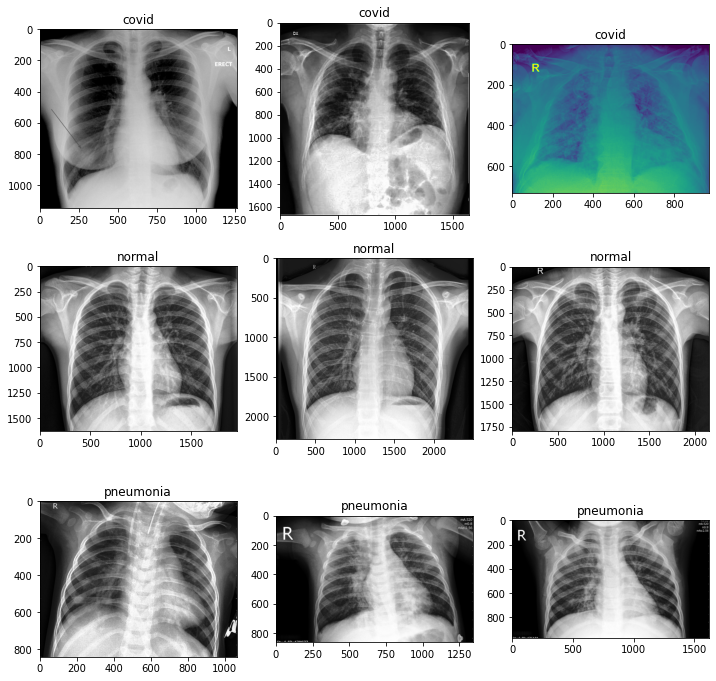

In [7]:
img_covid = os.listdir(train_covid_dir)
img_normal = os.listdir(train_normal_dir)
img_pneumonia = os.listdir(train_Pneumonia_dir)

fig = plt.gcf()
fig.set_size_inches(n_columns *4, n_rows*4)

pic_index += 3

next_covid_img = [('covid', os.path.join(train_covid_dir, fname)) for fname in img_covid[pic_index-3 : pic_index]]

next_normal_img = [('normal', os.path.join(train_normal_dir, fname)) for fname in img_normal[pic_index-3 : pic_index]]

next_pneumonia_img = [('pneumonia', os.path.join(train_Pneumonia_dir, fname)) for fname in img_pneumonia[pic_index-3 : pic_index]]

for i, img_type_path in enumerate(next_covid_img + next_normal_img + next_pneumonia_img):
  sp = plt.subplot(n_rows, n_columns, i +1)
  #sp.axis('Off')

  img = mpimg.imread(img_type_path[1])
  plt.imshow(img)
  plt.title(img_type_path[0])

plt.show()

In [55]:
@dataclass
class G:
  BATCH_SIZE : int = 64
  TARGET_SIZE : tuple = (224, 224)
  COLOR_MODE : str = 'rgb'
  TRAIN_DIR : str = os.path.join('./data/Covid19-dataset/train')
  VALID_DIR : str = os.path.join('./data/Covid19-dataset/test')

In [57]:
trainGen = ImageDataGenerator(rescale=1./255,
                              width_shift_range=0.05,
                              height_shift_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='constant',
                              cval=0.0)

train_gen = trainGen.flow_from_directory(G.TRAIN_DIR,
                                         shuffle=True,
                                         target_size= G.TARGET_SIZE,
                                         color_mode = G.COLOR_MODE,
                                         batch_size = G.BATCH_SIZE)

validGen = ImageDataGenerator(rescale=1./255)

valid_gen = validGen.flow_from_directory(G.VALID_DIR,
                                         target_size = G.TARGET_SIZE,
                                         color_mode = G.COLOR_MODE,
                                         batch_size = G.BATCH_SIZE)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


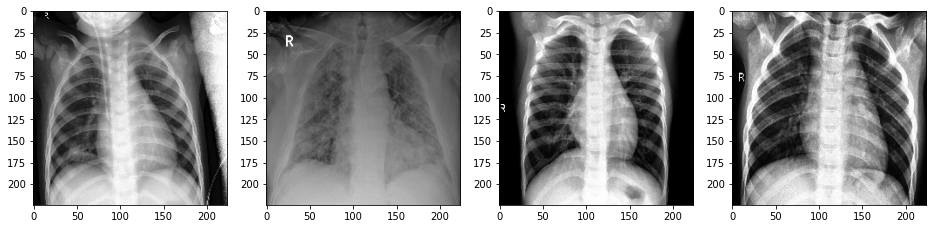

In [25]:
fig = plt.gcf()
fig.set_size_inches(4 *4, 4*4)

for i in range(4):
    img, label = valid_gen.next()
    sb = plt.subplot(1, 4, i +1)
    plt.imshow(img[0])
plt.show()

In [58]:
pretrained_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top = False,
                                                      weights = 'imagenet',
                                                      input_shape = (224, 224, 3))
for layer in pretrained_model.layers:
  layer.trainable = False

In [ ]:
pretrained_model.summary()

In [59]:
last_layer = pretrained_model.get_layer('conv5_block2_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 2048)


In [60]:
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)  
                 
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(pretrained_model.input, x)


In [ ]:
tf.keras.backend.clear_session()

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

model.summary()

In [48]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 10))

In [49]:
history = model.fit(train_gen,
                    epochs=50,
                    verbose=2,
                    callbacks=[lr_schedule],
                    validation_data=valid_gen)

Epoch 1/50
8/8 - 17s - loss: 1.3338 - accuracy: 0.2590 - val_loss: 1.1307 - val_accuracy: 0.4394 - lr: 1.0000e-07 - 17s/epoch - 2s/step
Epoch 2/50
8/8 - 13s - loss: 1.2486 - accuracy: 0.3147 - val_loss: 1.0901 - val_accuracy: 0.5455 - lr: 1.2589e-07 - 13s/epoch - 2s/step
Epoch 3/50
8/8 - 12s - loss: 1.1608 - accuracy: 0.3625 - val_loss: 1.0542 - val_accuracy: 0.5303 - lr: 1.5849e-07 - 12s/epoch - 2s/step
Epoch 4/50
8/8 - 13s - loss: 1.1622 - accuracy: 0.3506 - val_loss: 1.0289 - val_accuracy: 0.5152 - lr: 1.9953e-07 - 13s/epoch - 2s/step
Epoch 5/50
8/8 - 14s - loss: 1.1119 - accuracy: 0.3865 - val_loss: 1.0112 - val_accuracy: 0.4394 - lr: 2.5119e-07 - 14s/epoch - 2s/step
Epoch 6/50
8/8 - 14s - loss: 1.1226 - accuracy: 0.3984 - val_loss: 0.9951 - val_accuracy: 0.5152 - lr: 3.1623e-07 - 14s/epoch - 2s/step
Epoch 7/50
8/8 - 16s - loss: 1.0711 - accuracy: 0.4143 - val_loss: 0.9777 - val_accuracy: 0.6061 - lr: 3.9811e-07 - 16s/epoch - 2s/step
Epoch 8/50
8/8 - 14s - loss: 1.0327 - accuracy: 

(1e-07, 0.001, 0.0, 2.0)

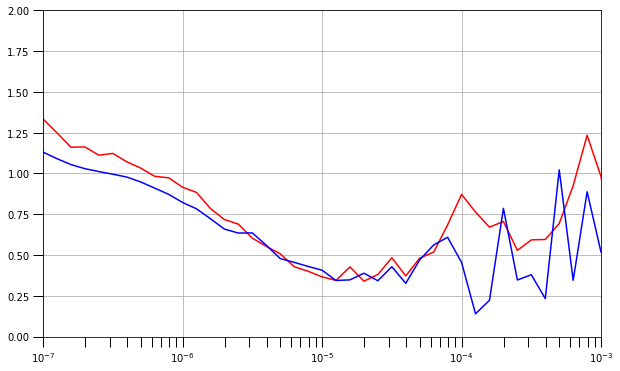

In [51]:
#------------------------------------------------
# Plot learning rate, loss, and validation loss per epoch
#------------------------------------------------
lrs = 1e-7 * (10 ** (np.arange(50) / 10))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, loss, 'r')
plt.semilogx(lrs, val_loss, 'b')
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-3, 0, 2])

In [61]:
tf.keras.backend.clear_session()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-6),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

history = model.fit(train_gen,
                    epochs=50,
                    verbose=2,
                    validation_data=valid_gen)

Epoch 1/50
4/4 - 19s - loss: 1.0150 - accuracy: 0.5458 - val_loss: 0.7753 - val_accuracy: 0.6364 - 19s/epoch - 5s/step
Epoch 2/50
4/4 - 13s - loss: 0.4814 - accuracy: 0.8207 - val_loss: 0.8429 - val_accuracy: 0.5152 - 13s/epoch - 3s/step
Epoch 3/50
4/4 - 12s - loss: 0.3823 - accuracy: 0.8367 - val_loss: 0.9316 - val_accuracy: 0.5303 - 12s/epoch - 3s/step
Epoch 4/50
4/4 - 13s - loss: 0.2798 - accuracy: 0.8924 - val_loss: 1.0635 - val_accuracy: 0.5455 - 13s/epoch - 3s/step
Epoch 5/50
4/4 - 12s - loss: 0.2443 - accuracy: 0.9084 - val_loss: 1.0961 - val_accuracy: 0.5000 - 12s/epoch - 3s/step
Epoch 6/50
4/4 - 12s - loss: 0.2572 - accuracy: 0.9004 - val_loss: 0.9507 - val_accuracy: 0.5455 - 12s/epoch - 3s/step
Epoch 7/50
4/4 - 12s - loss: 0.1838 - accuracy: 0.9243 - val_loss: 0.7103 - val_accuracy: 0.6818 - 12s/epoch - 3s/step
Epoch 8/50
4/4 - 12s - loss: 0.1552 - accuracy: 0.9323 - val_loss: 0.6138 - val_accuracy: 0.7424 - 12s/epoch - 3s/step
Epoch 9/50
4/4 - 12s - loss: 0.2102 - accuracy: 

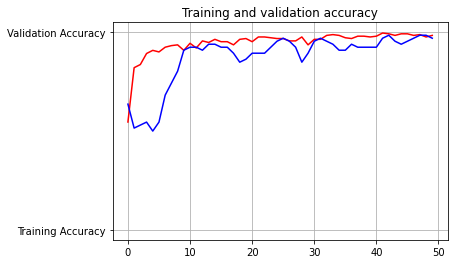

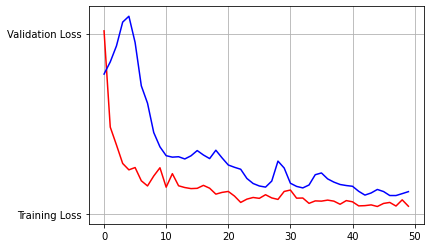

In [63]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.grid(True)
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.grid(True)
plt.show()